### Import the dataset and packages

The dataset is downloaded from Kaggle: [link](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv)

You can download it with the following link or download the train.csv file through Kaggle.

In [24]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
nltk.download('punkt')
import string

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
# read the dataset
df = pd.read_csv("./train.csv")

In [26]:
# how long is df?
df.shape

(7613, 5)

In [27]:
# look at the head
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
X = df['text']
y = df['target']

In [29]:
y.unique()

array([1, 0], dtype=int64)

In [30]:
X.unique()

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje',
       'Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

In [31]:
# # create a column that has the name of the target instead of its digit
# # call it label
# decode_map = {0: "not_disasterous", 1: "disasterous"}
# df['target'] = df['target'].map(decode_map)

# # you can do it with a function
# # def decode_sentiment(label):
#   #  return ...

# df.loc[:, 'label'] = ...

In [32]:
# create a column that has the name of the target instead of its digit
# call it label
decode_map = {0: "not_disasterous", 1: "disasterous"}

# you can do it with a function
def decode_sentiment(label):
  return decode_map[int(label)]

df.loc[:, 'label'] = df.target.apply(lambda x: decode_sentiment)

In [33]:
# check the null values
print('null values of each field:\n', ...)
df.isnull().sum()

null values of each field:
 Ellipsis


id             0
keyword       61
location    2533
text           0
target         0
label          0
dtype: int64

Text(0.5, 1.0, 'dataset labels distribution')

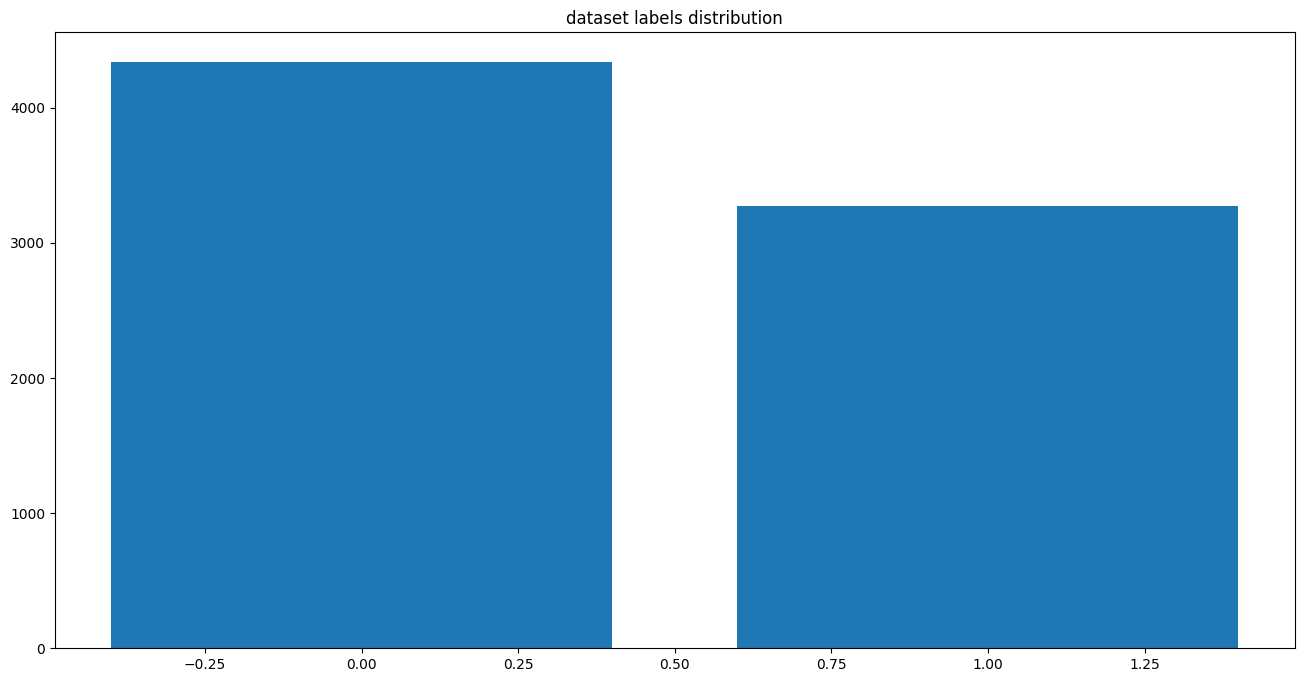

In [34]:
from collections import Counter
target_cnt = Counter(df.target)

plt.figure(figsize = [16,8])
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("dataset labels distribution")

In [35]:
# fill keyword and location with no_key and no_location
df.keyword.fillna('no_keyword', inplace = True)
df.location.fillna('no_location', inplace=True)

In [36]:
# visualize the number of negative and positive examples
target_cnt = Counter(df.target)

plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'number of tweets')

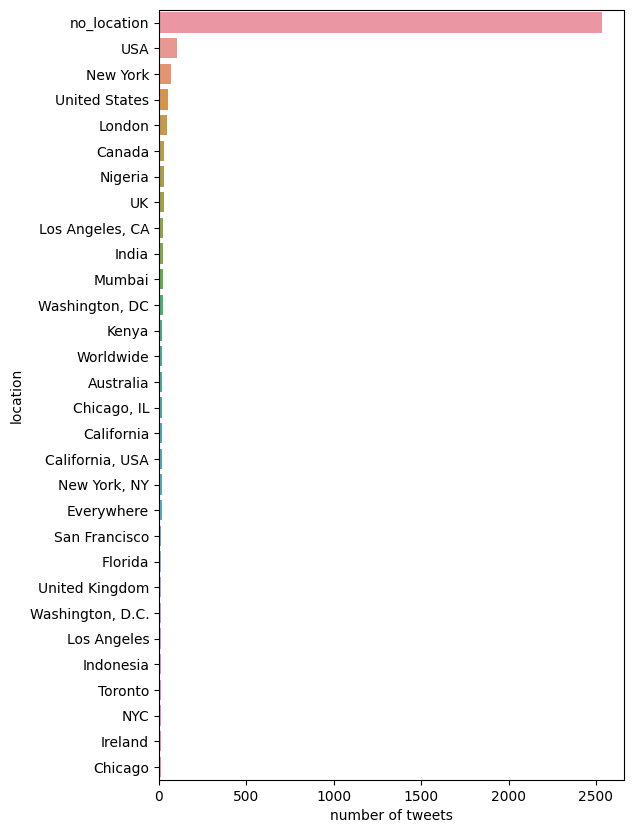

In [37]:
# what are the top 30 most frequently seen locations in the dataset

top_30 = df.groupby(['location']).count().text.sort_values(ascending = False)[:30]

# plot the names and their frequency
top_30
plt.figure(figsize = (6,10))
sns.barplot(x = top_30, y = top_30.index)
plt.xlabel('number of tweets')

### Preprocessing

In [38]:
def preprocess(text: str) -> str:
    # Lowercase all values
    text = text.lower()

    # Remove hyperlinks
    text = re.sub(r'\S*http?:\S*', '', text)

    # Remove mentions (starts with @)
    text = re.sub(r'[@#]\w*\_*', '', text)

    # Substitute patterns with their correct representation
    rep_character_entity_references = {
        "&gt;": ">",
        "&lt;": "<",
        "&amp;": "&"
    }

    for k, v in rep_character_entity_references.items():
        text = re.sub(k, v, text)

    return text

df.loc[:, 'cleaned_text'] = df.loc[:, "text"].apply(lambda x: preprocess(x))
df

,id,keyword,location,text,target,label,cleaned_text
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,<function decode_sentiment at 0x000002A7EDF8B060>,our deeds are the reason of this may allah fo...
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,<function decode_sentiment at 0x000002A7EDF8B060>,forest fire near la ronge sask. canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,<function decode_sentiment at 0x000002A7EDF8B060>,all residents asked to 'shelter in place' are ...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,<function decode_sentiment at 0x000002A7EDF8B060>,"13,000 people receive evacuation orders in ca..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,<function decode_sentiment at 0x000002A7EDF8B060>,just got sent this photo from ruby as smoke f...
...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1,<function decode_sentiment at 0x000002A7EDF8B060>,two giant cranes holding a bridge collapse int...
7609,10870,no_keyword,no_location,@aria_ahrary @TheTawniest The out of control w...,1,<function decode_sentiment at 0x000002A7EDF8B060>,the out of control wild fires in california ...
7610,10871,no_keyword,no_location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,<function decode_sentiment at 0x000002A7EDF8B060>,m1.94 [01:04 utc]?5km s of volcano hawaii.
7611,10872,no_keyword,no_location,Police investigating after an e-bike collided ...,1,<function decode_sentiment at 0x000002A7EDF8B060>,police investigating after an e-bike collided ...


Removing stopwords: When working with large language models, we usually don't remove stopwords as their removal might change the meaning of a word (e.g., both "she is happy" and "she isn't happy." will turn into "she happy"). However, when bulding visualizing the data, we need to get rid of these words to be able to project the essential words present in our data.

In [39]:
# nltk stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')

# spacy stopwords
import spacy
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = list(nlp.Defaults.stop_words.copy())


words_to_remove =  ['absolutely', "actually"]

all_stopwords = set(
    nltk_stopwords + spacy_stopwords + words_to_remove
    )

def remove_st(text:str) -> str:

    # Remove stopwords
    filtered_words = [word for word in text.split() if word not in all_stopwords]

    # Join the filtered words back into a sentence
    filtered_text = ' '.join(filtered_words)

    return filtered_text

# apply the remove st on cleaned_text
df.loc[:, 'cleaned_text_no_st'] = df.loc[:, 'cleaned_text'].apply(lambda x: remove_st(x))
df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target,label,cleaned_text,cleaned_text_no_st
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,<function decode_sentiment at 0x000002A7EDF8B060>,our deeds are the reason of this may allah fo...,deeds reason allah forgive
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,<function decode_sentiment at 0x000002A7EDF8B060>,forest fire near la ronge sask. canada,forest fire near la ronge sask. canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,<function decode_sentiment at 0x000002A7EDF8B060>,all residents asked to 'shelter in place' are ...,residents asked 'shelter place' notified offic...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,<function decode_sentiment at 0x000002A7EDF8B060>,"13,000 people receive evacuation orders in ca...","13,000 people receive evacuation orders califo..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,<function decode_sentiment at 0x000002A7EDF8B060>,just got sent this photo from ruby as smoke f...,got sent photo ruby smoke pours school
...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1,<function decode_sentiment at 0x000002A7EDF8B060>,two giant cranes holding a bridge collapse int...,giant cranes holding bridge collapse nearby homes
7609,10870,no_keyword,no_location,@aria_ahrary @TheTawniest The out of control w...,1,<function decode_sentiment at 0x000002A7EDF8B060>,the out of control wild fires in california ...,control wild fires california northern state. ...
7610,10871,no_keyword,no_location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,<function decode_sentiment at 0x000002A7EDF8B060>,m1.94 [01:04 utc]?5km s of volcano hawaii.,m1.94 [01:04 utc]?5km volcano hawaii.
7611,10872,no_keyword,no_location,Police investigating after an e-bike collided ...,1,<function decode_sentiment at 0x000002A7EDF8B060>,police investigating after an e-bike collided ...,police investigating e-bike collided car littl...


In [40]:
def remove_punctuation_and_digits(text:str) -> str:

    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Remove digits
    text = re.sub(r'\d', '', text)

    # removes all single letters surrounded with space except letters I and a
    text = re.sub(r'(?:^|\s)(?![ia])[a-z] +', '', text)

    return text

In [41]:
df.loc[:, 'cleaned_text'] = df.loc[:, 'cleaned_text'].apply(lambda x: remove_punctuation_and_digits(x))
df.loc[:, 'cleaned_text_no_st'] = df.loc[:, 'cleaned_text_no_st'].apply(lambda x: remove_punctuation_and_digits(x))

In [42]:
df

,id,keyword,location,text,target,label,cleaned_text,cleaned_text_no_st
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,<function decode_sentiment at 0x000002A7EDF8B060>,our deeds are the reason of this may allah fo...,deeds reason allah forgive
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,<function decode_sentiment at 0x000002A7EDF8B060>,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,<function decode_sentiment at 0x000002A7EDF8B060>,all residents asked to shelter in place are be...,residents asked shelter place notified officer...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,<function decode_sentiment at 0x000002A7EDF8B060>,people receive evacuation orders in california,people receive evacuation orders california
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,<function decode_sentiment at 0x000002A7EDF8B060>,just got sent this photo from ruby as smoke f...,got sent photo ruby smoke pours school
...,...,...,...,...,...,...,...,...
7608,10869,no_keyword,no_location,Two giant cranes holding a bridge collapse int...,1,<function decode_sentiment at 0x000002A7EDF8B060>,two giant cranes holding a bridge collapse int...,giant cranes holding bridge collapse nearby homes
7609,10870,no_keyword,no_location,@aria_ahrary @TheTawniest The out of control w...,1,<function decode_sentiment at 0x000002A7EDF8B060>,the out of control wild fires in california ...,control wild fires california northern state t...
7610,10871,no_keyword,no_location,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,<function decode_sentiment at 0x000002A7EDF8B060>,utckmof volcano hawaii,utckm volcano hawaii
7611,10872,no_keyword,no_location,Police investigating after an e-bike collided ...,1,<function decode_sentiment at 0x000002A7EDF8B060>,police investigating after an ebike collided w...,police investigating ebike collided car little...


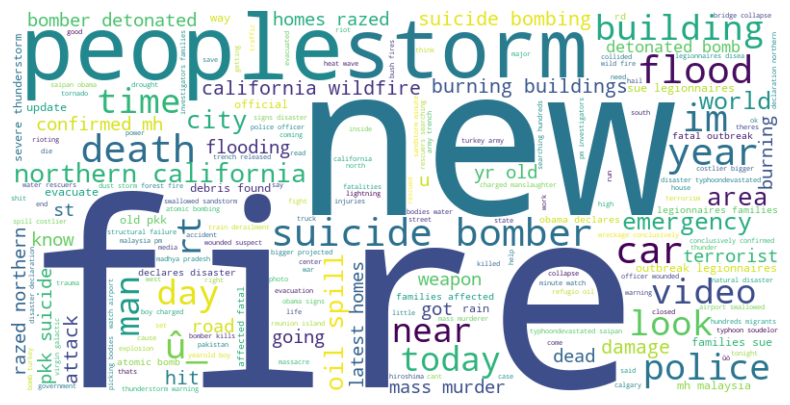

In [46]:
# build a word cloud for target == 0

from wordcloud import WordCloud

# Combine all text from the specified column into a single string
text = ' '.join(df[df.target==1]['cleaned_text_no_st'])
# print(text)
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color = 'white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
# build a word cloud for target == 1

# Combine all text from the specified column into a single string
text = ...

# Generate the word cloud
wordcloud = ...

# Display the word cloud using matplotlib
...

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [ ]:
# plot the most frequent words for target == 1

# Tokenize the text in the specified column
...

# Calculate the frequency distribution of tokens
...

# Display the most frequent words and their counts
...

# You can also plot a bar chart of the frequency distribution
...

### Prediction with RidgeClassifier, NaiveBayes, LinearSVM
Here we'll use counter vectorizer to specify one column for each word in the tweets and use it as a feature for prediction. If a tweet has a word, the column specife to that word will have the value of 1 (or more based on how many times that word has repeated in that tweet.)

As for the models, we chose these three because they can predict sparse data fast. You can go on and do gridsearch on them and find the best parameters for each.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# create a CountVectorizer function
counter_vectorizer = ...

# fit and transform the df
...
transformed_rows = ...


In [ ]:
# view the shape of transformed_rows
transformed_rows.shape

In [ ]:
# use the three algorithms and build cross validation to assess their performance
# make sure to create one pipeline with a feature selection algorithm inside it as well
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Assuming you have your target variable 'y' and features 'transformed_rows'
X = ...
y = ...

# Create a pipeline with feature selection and classifiers
ridge_pipeline = Pipeline([
    ...,
    ...
])

naive_bayes_pipeline = Pipeline([
    ...,
    ...
])

linear_svm_pipeline = Pipeline([
    ...,
    ...
])

# Define the classifiers
classifiers = {
    'Ridge Classifier': ridge_pipeline,
    'Naive Bayes': naive_bayes_pipeline,
    'Linear SVM': linear_svm_pipeline
}

# Perform stratified cross-validation and compare results
cv = ...

for name, clf in classifiers.items():
    y_pred = ...

    # Print confusion matrix and metrics
    print(f'\nResults for {name}:')
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(y, y_pred))

    accuracy = ...
    precision = ...
    recall = ...
    f1 = ...

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')


### Optional

Sentiment analysis with HuggingFace: [link](https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student)